In [114]:
import os
os.chdir(os.environ['PROJECT_DIR'])

import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("classic")

import numpy as np

from sklearn.manifold import TSNE

In [107]:
# load metadata
sen_metadata = pd.read_csv("data/raw/sen_metadata.csv")
sen_statements = pd.read_csv("data/processed/sen_statements.csv")

# load feature sets
tfidf_vectors = np.load("data/vectorized/sen_statements/id=ALL/tfidf_vectors.npy")
doc2vec_vectors = np.load("data/vectorized/sen_statements/id=ALL/doc2vec_vectors.npy")
bert_vectors = np.load("data/vectorized/sen_statements/id=ALL/bert_vectors.npy")

# Dataset Exploration

### Democrat vs Republican vs Independent Visualization

In [108]:
member_to_party = dict(zip(sen_metadata['member_id'], sen_metadata['party']))
member_to_name = dict(zip(sen_metadata['member_id'], sen_metadata['name']))
party_to_color = {'D': 'blue', 'R': 'red', 'ID': 'green', 'I': 'green'}

In [109]:
plot_sample = sen_statements.sample(frac=.10, random_state=2023)
plot_sample_idxs = plot_sample.index.to_list()
bert_vectors_sample = bert_vectors.take(plot_sample_idxs, axis=0)

In [125]:
bert_vectors_tsne = TSNE(n_components=2, learning_rate='auto', init='pca', perplexity=100).fit_transform(bert_vectors_sample)

/Users/chasemattingly/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


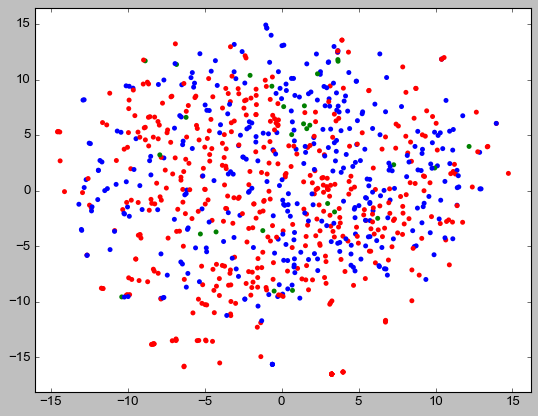

In [126]:
plt.scatter(bert_vectors_tsne[:, 0], 
            bert_vectors_tsne[:, 1], 
            c=plot_sample['member_id'].apply(lambda x: party_to_color[member_to_party[x]]))

In [112]:
'''
We can see from the visualization above that the BERT document embeddings, the embeddings with the most semantic meaning, are not easily distinguishable between parties.
Therefore, in order to get a more meaningful visualization, I believe that the document topic embeddings will possibly give us more information to distingush content being
discussed between parties.
'''

'\nWe can see from the visualization above that the BERT document embeddings, the embeddings with the most semantic meaning, are not easily distinguishable between parties.\nTherefore, in order to get a more meaningful visualization, I believe that the document topic embeddings will possibly give us more information to distingush content being\ndiscussed between parties.\n'

### Dust and Magnet Topic Modeling Visualization

You can find the visualization on our research lab website [here](https://outliers.das-lab.org)

### Senators with least amount of statements

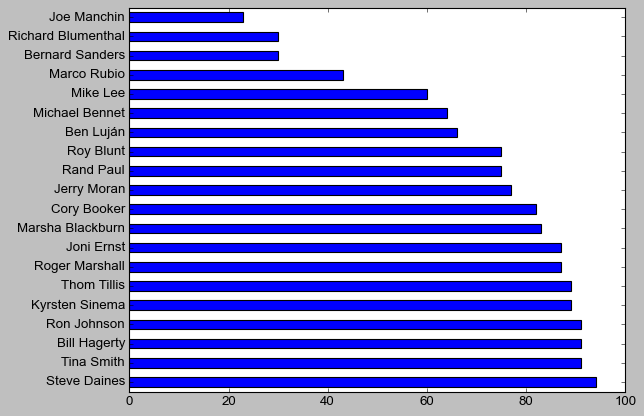

In [124]:
sen_statements['member_id'].apply(lambda x: member_to_name[x]) \
    .value_counts()[-20:] \
    .plot(kind='barh')